<a href="https://colab.research.google.com/github/sjamthe/spacex-launch-analysis/blob/main/spacex_launch_parser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This parser downloads a spacex launch video from YouTube and parses launch parameters (speed, height, time)

## 1. Connect to GDrive

In [1]:
# Check is Link to Drive is OK
google = !if [ -d 'GDrive/' ]; then echo "1" ; else echo "0"; fi
if (google[0] is '0' ):
  from google.colab import drive
  drive.mount('/content/GDrive/')
!if [ -d 'GDrive/' ]; then echo "Connection to Google drive successful" ; else echo "Error to connect to Google drive"; fi

Mounted at /content/GDrive/
Connection to Google drive successful


In [2]:
GDRIVE_TMP = '/content/GDrive/MyDrive/SXM-8'
!if [ -d {GDRIVE_TMP} ]; then echo "Output to be stored in "{GDRIVE_TMP} ; else mkdir -p {GDRIVE_TMP} && echo "Output directory created"; fi


Output to be stored in /content/GDrive/MyDrive/SXM-8


# 2. Select stream and download Video

In [3]:
!pip install pytube

     |████████████████████████████████| 51kB 5.7MB/s 


In [4]:
from pytube import YouTube

url = "https://www.youtube.com/watch?v=6b6uhHbGAXQ"
yt = YouTube(url)
streams = yt.streams

In [5]:
#confirm we have a 720p stream with progressive=True
stream = streams.filter(res="720p",progressive=True).first()
stream

<Stream: itag="22" mime_type="video/mp4" res="720p" fps="30fps" vcodec="avc1.64001F" acodec="mp4a.40.2" progressive="True" type="video">

In [6]:
#if above is not null download the stream else select progressive=False and try
video = stream.download(GDRIVE_TMP)

In [7]:
import cv2

def get_video_info(videofilename):
  cv2video = cv2.VideoCapture(videofilename)
  height = cv2video.get(cv2.CAP_PROP_FRAME_HEIGHT)
  width  = cv2video.get(cv2.CAP_PROP_FRAME_WIDTH) 
  print ("Video Dimension: height:{} width:{}".format( height, width))

  framecount = cv2video.get(cv2.CAP_PROP_FRAME_COUNT ) 
  frames_per_sec = cv2video.get(cv2.CAP_PROP_FPS)
  print("Video FPS {}, Total Frames {}".format(frames_per_sec, framecount))
  print("Video duration (sec):", framecount / frames_per_sec)

In [8]:
#verify downloaded video specs
get_video_info(video)

Video Dimension: height:718.0 width:1280.0
Video FPS 29.943, Total Frames 16156.0
Video duration (sec): 539.5584944728317


# 3. Extract video

In [9]:
# skip=0 means extract all images, default 30 means 1 image per second for fps=30
import cv2 as cv2 
from skimage import io
from skimage.color import rgb2gray
from skimage.transform import resize
import matplotlib.pylab as plt

def extract_images(video, start=0, stop=-1, skip=30, folder=GDRIVE_TMP):
  count = 0
  success = True

  OUTPUT_FRAMES_PATH = folder + '/frames'      # Location of extracted images
  !if [ -d {OUTPUT_FRAMES_PATH} ]; then echo "Output to be stored in "{OUTPUT_FRAMES_PATH} ; else mkdir -p {OUTPUT_FRAMES_PATH} && echo "Output directory created"; fi

  frame_name = 'frame'
  vidcap = cv2.VideoCapture(video)

  %%timeit
  for i in range(start):
    success = vidcap.grab()
    count += 1 
    if success == False:
      print("ERROR: Skipping to {} failed after {}".format(start, i))
      return count
    if count%1800 == 0:
      print("skipped ",count)

  %%timeit
  while success:
      if (skip == 0 or count%skip == 0):                                # checks frame number and keeps one_frame_each          
          success,image = vidcap.read()                                 # reads next frame           
          #image_gray = rgb2gray(image)                                  # grayscale image
          #if image.shape[1]>640:                                        # if image width > 640, resize it
          #  image_gray = resize(image_gray, (math.floor(640 / image_gray.shape[1] * image_gray.shape[0]), 640),mode='constant')
          #plt.imsave("%s/%s%d.png" % (OUTPUT_FRAMES_PATH,frame_name, count), image_gray, cmap= plt.cm.gray) # saves images to frame folder
          plt.imsave("%s/%s%d.png" % (OUTPUT_FRAMES_PATH,frame_name, count), image) # saves images to frame folder
          #print ('*', end="")
      else:
          #success,image = vidcap.read()                                 # reads next frame
          success = vidcap.grab()
      count += 1 
      if count%1800 == 0:
        print("read",count)

      if stop > start and count > stop:
        break
      
  return count                                                       # loops counter

In [10]:
start = 0
skip = 15
frame_cnt = extract_images(video, start=start, skip=skip)

Output directory created
read 1800
read 3600
read 5400
read 7200
read 9000
read 10800
read 12600
read 14400


In [11]:
frame_cnt

16157

# 4. Visually verify image and define crop areas for telematics (enable GPU)

In [54]:
from google.colab.patches import cv2_imshow # for image display
import cv2
import os

def read_image(serialno, folder=GDRIVE_TMP):
  filename = folder + '/frames/frame' + str(serialno) + '.png'
  #print (filename)
  if os.path.isfile(filename):
    image = cv2.imread(filename)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  #Images were saved as BGR sometimes
  else:
    image = None  
  return image

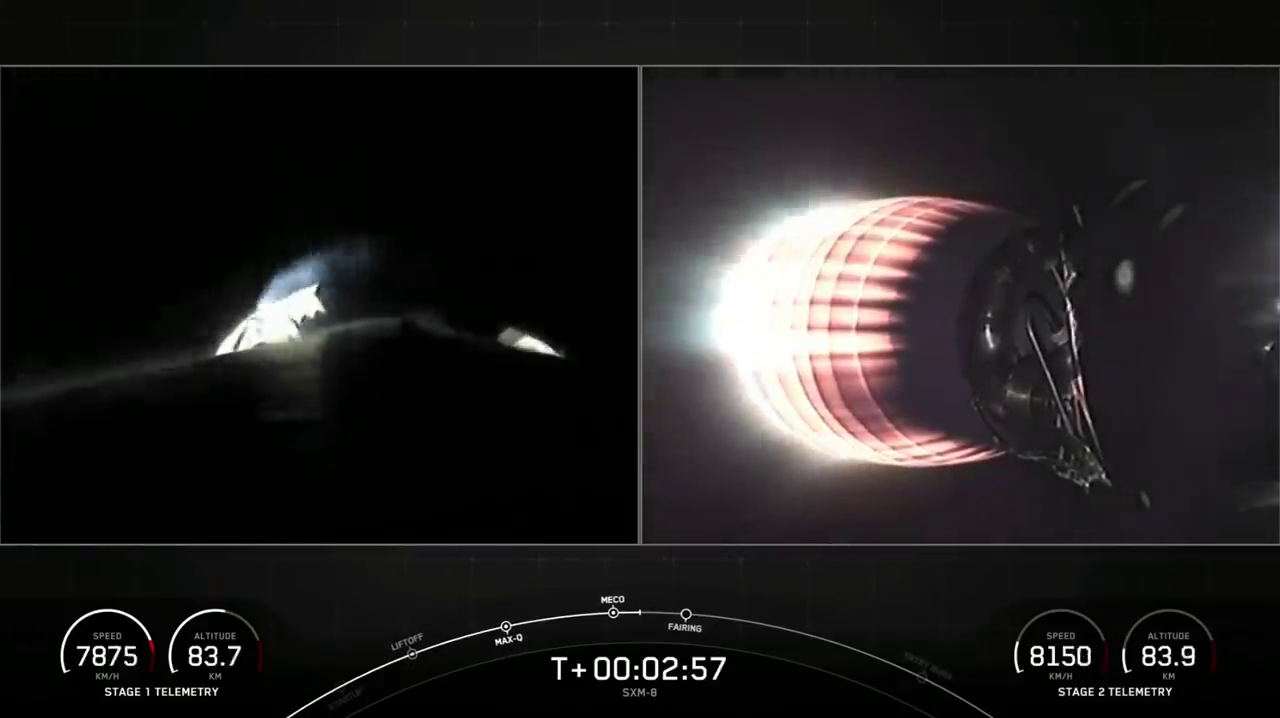

In [55]:
# normally image 3 minutes from start has both stage telematics
min = 6
start = 0
skip = 15
cnt = start + skip * min * 60
image = read_image(cnt)
cv2_imshow(image)

## Define (global) cropping arrays

In [57]:
st1_speed_crop = [-75, -48, 64, 150]
img = image[st1_speed_crop[0]:st1_speed_crop[1],st1_speed_crop[2]:st1_speed_crop[3]]
cv2_imshow(img)

In [59]:
st1_alt_crop = [-75, -48, 172, 250]
img = image[st1_alt_crop[0]:st1_alt_crop[1],st1_alt_crop[2]:st1_alt_crop[3]]
cv2_imshow(img)

In [72]:
st2_speed_crop = [-75, -48, -261, -184]
img = image[st2_speed_crop[0]:st2_speed_crop[1],st2_speed_crop[2]:st2_speed_crop[3]]
cv2_imshow(img)

In [73]:
st2_alt_crop = [-75, -48, -150, -60]
img = image[st2_alt_crop[0]:st2_alt_crop[1],st2_alt_crop[2]:st2_alt_crop[3]]
cv2_imshow(img)

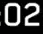

In [74]:
time_min_crop = [-64, -30, 638, 681]
img = image[time_min_crop[0]:time_min_crop[1],time_min_crop[2]:time_min_crop[3]]
cv2_imshow(img)

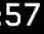

In [76]:
time_sec_crop = [-64, -30, 686, 730]
img = image[time_sec_crop[0]:time_sec_crop[1],time_sec_crop[2]:time_sec_crop[3]]
cv2_imshow(img)

# 5. Test OCR of sample images  (use GPU)

In [ ]:
!pip install easyocr

In [4]:
# OCR all frames
import easyocr
import numpy as np

reader = easyocr.Reader(['en'],gpu=True)

In [5]:
def scan(img, crop):
  # we are only looking for numbers and decimal so create an allow list
  allowlist = "0123456789."

  cropped_img = img[crop[0]:crop[1], crop[2]:crop[3]]
  texts = reader.readtext(cropped_img, allowlist=allowlist, detail=0)
  if len(texts) > 0:
    val = texts[0]
  else:
    val = None
  
  return val

def ocr_parser(image):
  st1_speed = scan(image, st1_speed_crop)
  st1_alt = scan(image, st1_alt_crop)
  st2_speed = scan(image, st2_speed_crop)
  st2_alt = scan(image, st2_alt_crop)
  time_min = scan(image, time_min_crop)
  time_sec = scan(image, time_sec_crop)

  return [time_min,time_sec,st1_speed,st1_alt,st2_speed,st2_alt]


In [77]:
ocr_parser(image)

['02', '57', '7875', '83.7', '8150', '83.9']

# Scan all images and save telematics data (use GPU)

In [18]:
def scan_all_images(start=0, stop=99999999, skip=30):
  count = 0
  srl = 0
  arr = []
  while start < stop  and srl < stop:
    srl = start + skip * count
    count += 1
    if srl < start:
      continue
    
    #print (srl)
    image = read_image(srl) #This name has to be image to allow eval
    if image is None:
      print ("Error: missing image for serial {}, image count {}".format(srl, count))
      break
    rowval = [srl] + ocr_parser(image)
    arr.append(rowval)

  return arr

In [99]:
arr = scan_all_images(start=0, skip=30)

Error: missing image for serial 16170, image count 540


In [100]:
len(arr)

539

In [101]:
#save the results to GDrive as ocr take a while to run even with GPUs
# we can release GPU after this
import pickle
pickle.dump(arr, open( GDRIVE_TMP + '/results.p', "wb" ) )

# Data scrub & calculate G's

In [22]:
import pandas as pd

# return a data frame with columns
# image_srl, time_secs, stage1_speed, stage1_altitude, stage2_speed, stage2_altitude
def calc_telematics(arr):
  data = []
  for row in arr:
    [srl, min, sec, speed1, alt1, speed2, alt2]  = row
    # skip row if all telematics are None
    if speed1 == None and alt1 == None and speed2 == None and alt2 == None:
      print ("skipping for None values at image {} and time {}:{}".format(srl,min,sec))
      continue

    try:
      time_secs = int(min)*60 + int(sec)
    except:
      print ("skipping for bad time at image {} and time {}:{}".format(srl,min,sec))
      continue
    
    try:
      speed1_val = float(speed1)
    except:
      speed1_val = None  
    try:
      alt1_val = float(alt1)
    except:
      alt1_val = None  
    try:
      speed2_val = float(speed2)
    except:
      speed2_val = None  
    try:
      alt2_val = float(alt2)
    except:
      alt2_val = None  

    data.append([srl, time_secs, speed1_val, alt1_val, speed2_val, alt2_val])

  df = pd.DataFrame (data, columns = ['image_srl', 'time_secs', 'stage1_speed',
                                      'stage1_altitude','stage2_speed', 
                                      'stage2_altitude'])
  return df

In [23]:
import pickle

arr = pickle.load( open( GDRIVE_TMP + '/results.p', "rb" ) )

In [102]:
df = calc_telematics(arr)
df.describe()

skipping for None values at image 0 and time 00:04


,image_srl,time_secs,stage1_speed,stage1_altitude,stage2_speed,stage2_altitude
count,538.000000,538.000000,512.000000,520.000000,363.000000,3.670000e+02
mean,8085.000000,269.756506,4976.998047,56.340865,16006.250138,2.770502e+06
std,4663.544789,159.199552,3003.968906,45.308185,6391.980355,5.306738e+07
min,30.000000,0.000000,0.000000,0.000000,8.800000,8.060000e+01
25%,4057.500000,132.250000,1502.250000,10.575000,10370.500000,1.415000e+02
50%,8085.000000,269.500000,7012.000000,49.400000,14412.000000,1.640000e+02
75%,12112.500000,405.750000,7507.250000,103.250000,21132.000000,1.660000e+02
max,16140.000000,545.000000,8237.000000,123.000000,26853.000000,1.016625e+09


In [103]:
# replace stage2 telematics when stage2 is attached to stage1
df.loc[(df.stage2_speed < df.stage1_speed) | (df.stage2_speed.isnull()) , 'stage2_altitude'] = df.stage1_altitude
df.loc[(df.stage2_speed < df.stage1_speed) | (df.stage2_speed.isnull()) , 'stage2_speed'] = df.stage1_speed

In [104]:
#check 
df[df.stage2_altitude > 199]

,image_srl,time_secs,stage1_speed,stage1_altitude,stage2_speed,stage2_altitude


In [105]:
#check stage2_speed
df[df.stage2_speed > 30000]

,image_srl,time_secs,stage1_speed,stage1_altitude,stage2_speed,stage2_altitude


In [106]:
#verify one more time min, max values make sense
df.describe()

,image_srl,time_secs,stage1_speed,stage1_altitude,stage2_speed,stage2_altitude
count,538.000000,538.000000,512.000000,520.000000,536.000000,538.000000
mean,8085.000000,269.756506,4976.998047,56.340865,11830.526119,109.559721
std,4663.544789,159.199552,3003.968906,45.308185,8169.420338,63.590137
min,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4057.500000,132.250000,1502.250000,10.575000,5645.500000,43.275000
50%,8085.000000,269.500000,7012.000000,49.400000,10549.500000,143.000000
75%,12112.500000,405.750000,7507.250000,103.250000,17354.750000,164.000000
max,16140.000000,545.000000,8237.000000,123.000000,26853.000000,168.000000


In [107]:
#Calculate G (convert speed from km/h to m/s), calculate G with delta 4 secs fo smoothness
# speed/time_secs*1000/3600/9.81
delta = 5
accdiff = df.stage1_speed.diff(delta)*1000.0/3600.0
secdiff = df.time_secs.diff(delta)
acc = accdiff/secdiff
df['stage1_g'] = acc/9.81

In [108]:
#Calculate G (convert speed from km/h to m/s), calculate G with delta 4 secs fo smoothness
# speed/time_secs*1000/3600/9.81
delta = 5
accdiff = df.stage2_speed.diff(delta)*1000.0/3600.0
secdiff = df.time_secs.diff(delta)
acc = accdiff/secdiff
df['stage2_g'] = acc/9.81

In [109]:
df.describe()

,image_srl,time_secs,stage1_speed,stage1_altitude,stage2_speed,stage2_altitude,stage1_g,stage2_g
count,538.000000,538.000000,512.000000,520.000000,536.000000,538.000000,507.000000,531.000000
mean,8085.000000,269.756506,4976.998047,56.340865,11830.526119,109.559721,0.022762,1.394124
std,4663.544789,159.199552,3003.968906,45.308185,8169.420338,63.590137,1.526585,1.016906
min,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-5.306377,-0.475705
25%,4057.500000,132.250000,1502.250000,10.575000,5645.500000,43.275000,-0.345452,0.620116
50%,8085.000000,269.500000,7012.000000,49.400000,10549.500000,143.000000,0.080228,1.198701
75%,12112.500000,405.750000,7507.250000,103.250000,17354.750000,164.000000,0.506852,1.979273
max,16140.000000,545.000000,8237.000000,123.000000,26853.000000,168.000000,3.307283,4.091630


In [91]:
import seaborn as sns

# Apply the default theme
sns.set_theme()

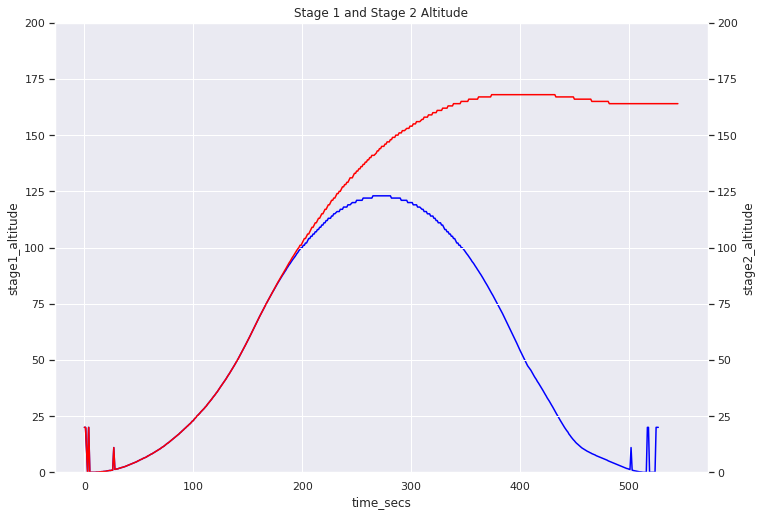

In [110]:
import matplotlib.pylab as plt

sns.set(rc={'figure.figsize':(11.7,8.27)})

fig, ax1 = plt.subplots() # initializes figure and plots
ax1.set(ylim=(0, 200))

ax2 = ax1.twinx() # applies twinx to ax2, which is the second y axis. 
ax2.set(ylim=(0, 200))

sns.lineplot(x="time_secs", y="stage1_altitude",ax = ax1, data=df, color='blue');
sns.lineplot(x="time_secs", y="stage2_altitude",ax = ax2, data=df, color='red');
plt.title("Stage 1 and Stage 2 Altitude")

plt.show(); # shows the plot.

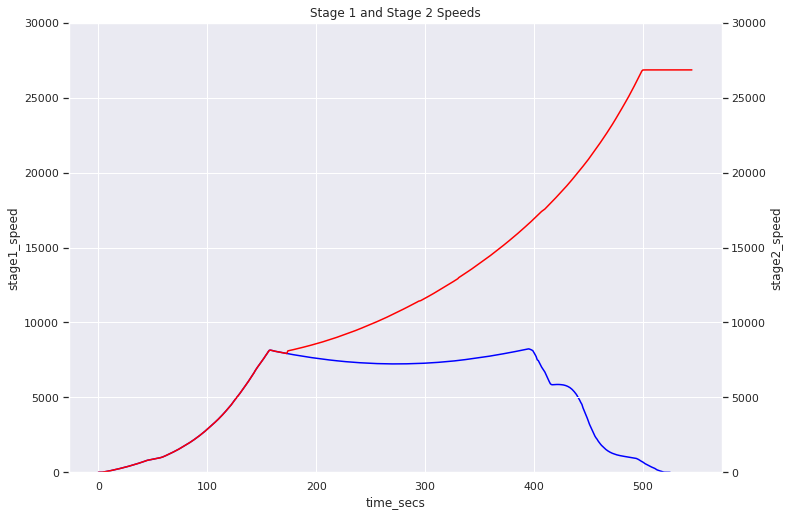

In [111]:
import matplotlib.pylab as plt

sns.set(rc={'figure.figsize':(11.7,8.27)})

fig, ax1 = plt.subplots() # initializes figure and plots
ax1.set(ylim=(0, 30000))

ax2 = ax1.twinx() # applies twinx to ax2, which is the second y axis. 
ax2.set(ylim=(0, 30000))

sns.lineplot(x="time_secs", y="stage1_speed",ax = ax1, data=df, color='blue');
sns.lineplot(x="time_secs", y="stage2_speed",ax = ax2, data=df, color='red');
plt.title("Stage 1 and Stage 2 Speeds")

plt.show(); # shows the plot.

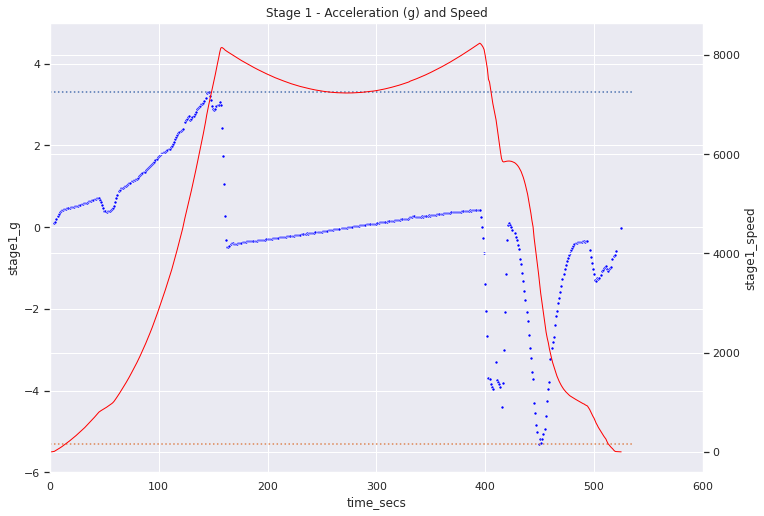

In [114]:
import matplotlib.pylab as plt

sns.set(rc={'figure.figsize':(11.7,8.27)})

fig, ax1 = plt.subplots() # initializes figure and plots
ax2.set(ylim=(0, 8000))

ax2 = ax1.twinx() # applies twinx to ax2, which is the second y axis. 
ax1.set(ylim=(-6, 5))
ax1.set(xlim=(0, 600))

sns.scatterplot(x="time_secs", y="stage1_g",ax = ax1, data=df, color='blue', marker=".");
sns.lineplot(x="time_secs", y="stage1_speed",ax = ax2, data=df, color='red',  linewidth = 1);

#show max_g1 line
max_g1_secs = df.stage1_g.max()
ax1.plot([0,df.index.max()], [max_g1_secs, max_g1_secs],label="line", linestyle="dotted")

#show min_g1 line
min_g1_secs = df[0:df.index.max()].stage1_g.min()
ax1.plot([0,df.index.max()], [min_g1_secs, min_g1_secs],label="line", linestyle="dotted")


plt.title("Stage 1 - Acceleration (g) and Speed")
plt.show(); # shows the plot.

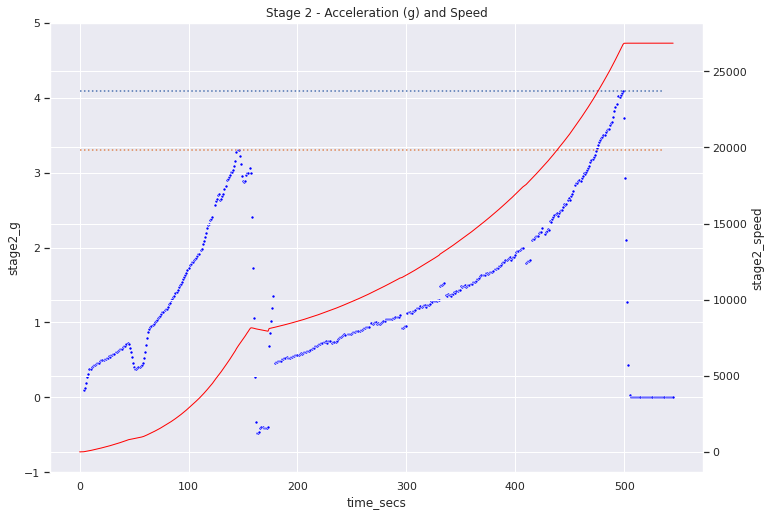

In [115]:
import matplotlib.pylab as plt

sns.set(rc={'figure.figsize':(11.7,8.27)})
fig, ax1 = plt.subplots() # initializes figure and plots
ax2.set(ylim=(10, 8000))

ax2 = ax1.twinx() # applies twinx to ax2, which is the second y axis. 
ax1.set(ylim=(-1, 5))

sns.scatterplot(x="time_secs", y="stage2_g",ax = ax1, data=df, color='blue',marker=".");
sns.lineplot(x="time_secs", y="stage2_speed",ax = ax2, data=df, color='red', linewidth = 1);

#show max_g2 line
max_g2_secs = df.stage2_g.max()
ax1.plot([0,df.index.max()], [max_g2_secs, max_g2_secs],label="line", linestyle="dotted")

#show max_g1 line
max_g1_secs = df.stage1_g.max()
ax1.plot([0,df.index.max()], [max_g1_secs, max_g1_secs],label="line", linestyle="dotted")

plt.title("Stage 2 - Acceleration (g) and Speed")
plt.show(); # shows the plot.

In [116]:
df.stage1_g.max()


3.3072828179861817

In [117]:
df.stage2_g.max()


4.09162985615585

In [118]:
min_g1_secs

-5.306376713104542